En este proyecto vamos a utilizar el algoritmo de Regresión logística para poder clasificar las personas que murieron y las que no durante el hundimiento del Titanic.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv(r'titanic_train.csv')

In [3]:
train.shape

(891, 12)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Vemos los datos que faltan en cada una de las columnas del dataframe. Dichos valores faltantes son los que aparecen en amarillo.

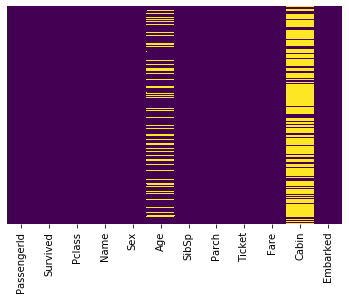

In [9]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Aproximadamente el 80% son valores nulos para la etiqueta "Cabin"

In [13]:
train['Cabin'].isnull().value_counts(normalize=True)*100

True     77.104377
False    22.895623
Name: Cabin, dtype: float64

Mientras que en la columna de edad solo el 20% esta perdido

In [14]:
train['Age'].isnull().value_counts(normalize=True)*100

False    80.13468
True     19.86532
Name: Age, dtype: float64

Exploremos un poco más los datos

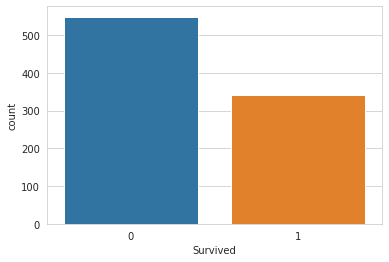

In [16]:
sns.set_style('whitegrid')
sns.countplot(train['Survived'])
#or
#sns.countplot(x='Survived', data=train)

Veamos cuantos de los que sobrevivieron fueron hombre y cuantas mujeres

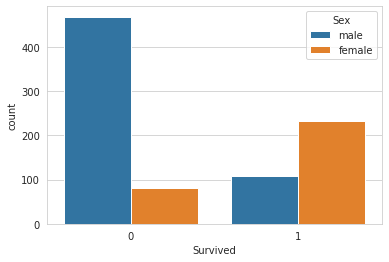

In [19]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train, hue='Sex')

Además veamos de que clase eran los sobrevivientes y los que murieron

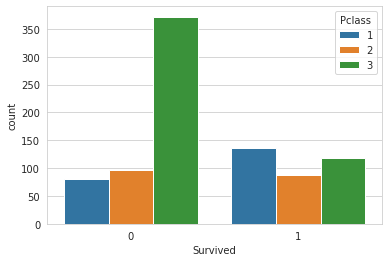

In [20]:
sns.countplot(x='Survived', data=train, hue='Pclass')

In [27]:
train['Age'].isnull().sum()

177

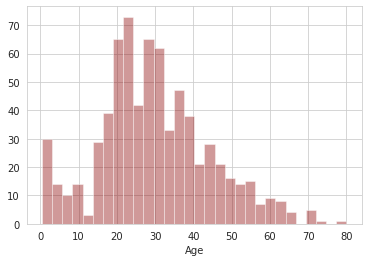

In [31]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

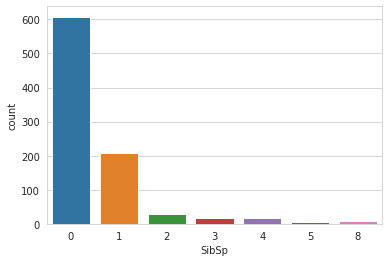

In [33]:
sns.countplot(train['SibSp'])

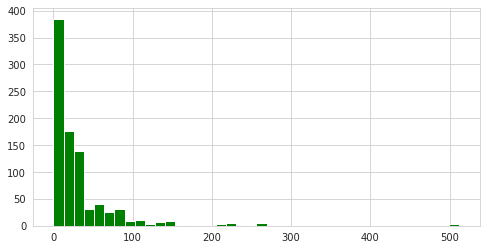

In [34]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

Limpieza de los datos:
Por parte de la columna edad, en vez de tirar las filas faltantes las llenamos con la edad promedio de los pasajeros.

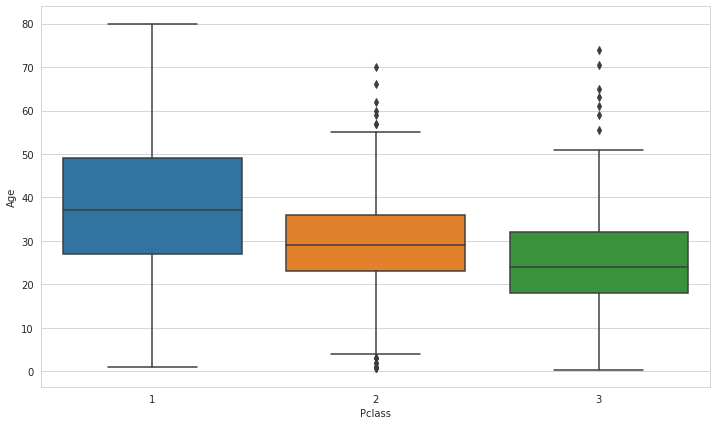

In [40]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Pclass', y='Age', data=train)

In [43]:
def impute_age(cols):
    Age=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        
        if Pclass==1:
            return 37
        
        elif Pclass==2:
            return 29
        
        else:
            return 24
    
    else:
        return Age

Implementamos la función en la columna Age

In [44]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

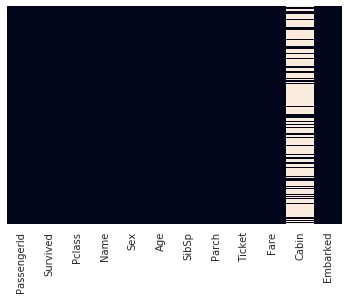

In [52]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

In [53]:
train['Embarked'].isnull().sum()

2

Tiramos la columna Cabin debido a la cantidad de datos faltantes

In [58]:
train.drop('Cabin', axis=1, inplace=True)

A las 2 filas de Embarked sin datos las eliminamos debido a que no alteran los datos

In [61]:
train.dropna(inplace=True)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [67]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Reasignamos algunas variables para poder trabajar con el alritmo de regresión.

In [68]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [71]:
train.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True)

In [72]:
train = pd.concat([train, sex, embark], axis=1)

In [73]:
train.sample(9)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
198,199,1,3,24.0,0,0,7.7500,0,1,0
767,768,0,3,30.5,0,0,7.7500,0,1,0
718,719,0,3,24.0,0,0,15.5000,1,1,0
146,147,1,3,27.0,0,0,7.7958,1,0,1
655,656,0,2,24.0,2,0,73.5000,1,0,1
589,590,0,3,24.0,0,0,8.0500,1,0,1
653,654,1,3,24.0,0,0,7.8292,0,1,0
10,11,1,3,4.0,1,1,16.7000,0,0,1
532,533,0,3,17.0,1,1,7.2292,1,0,0


Los datos están listos para el modelo

Train Test Split

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived', axis=1), train['Survived'], 
                                                                test_size=0.3, random_state=101)

Entrenamiento y predicción

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

/home/jerefarrher/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
predictions = logmodel.predict(X_test)

Evaluación del modelo

In [87]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       163
           1       0.85      0.65      0.74       104

    accuracy                           0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



In [89]:
from sklearn.metrics import confusion_matrix

In [92]:
print(confusion_matrix(y_test, predictions))

[[151  12]
 [ 36  68]]
